# Machine learning with faces

In this notebook, we will quickly walk through three basic machine learning tasks, using a dataset of face images, the so-called "Olivetti faces" ([link](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset)). We start with dimension reduction using principal component analysis (PCA), then we build a simple classifier to recognize different people from their faces, and finally we build a simple regression model to predict the bottom half of a picture from the top half.

Please note that this notebook only demonstrates how to quickly implement some simple machine learning models. Most importantly, we are not doing any kind of cross-validation in this notebook. It will be pointed out inline where such cross-validation schemes should be implemented.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.decomposition
import sklearn.model_selection
import sklearn.tree
import sklearn.ensemble

## Dimension reduction with PCA

We begin by loading the dataset via scikit-learn. We save it into this project's folder in order to not have to download it multiple times.

In [4]:
X, y = sklearn.datasets.fetch_olivetti_faces(return_X_y=True, data_home='data')

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to data


We usually being by exploring the data a bit, e.g. by checking how many features and samples we have, and what the range of input and output data is:

In [5]:
X.shape

(400, 4096)

In [6]:
y.shape

(400,)

In [7]:
X.min(), X.max()

(0.0, 1.0)

In [11]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

We can see that our input are 400 vectors, each of which is 4096-dimensional ($64 \times 64$ images). The values for the images lie in the range $[0,1]$. The output is a numerical label and we have 40 categories in total.

Let us plot an example image:

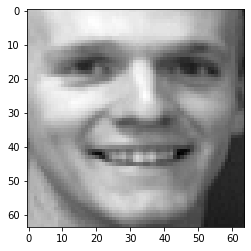

In [14]:
plt.imshow(X[42].reshape(64, 64), cmap=plt.cm.gray);

Note that we have to reshape the 4096-dimensional vector into a 2-dimensional array of shape `(64, 64)`. The `cmap` argument control the color map that we are using to plot the image. We are using the `gray` color map, since we are working with grayscale images. 

Let us now implement the PCA. To do that, we need to split the data into training and testing. We can do that manually, by shuffling the training data, but `sklearn` provides us with a convenient function for it, so we will use that. We will do a 80/20 split, and we specify a `random_state` (this is basically a random seed for the function to make sure that it's split the same way every time we call the function, for reproducibility). 

In [21]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

This yields 320 training samples and 80 testing samples:

In [25]:
X_train.shape, X_test.shape

((320, 4096), (80, 4096))

We now run PCA with 100 components:

In [18]:
pca = sklearn.decomposition.PCA(n_components=100)
pca.fit(X_train)

PCA(n_components=100)

In order to evaluate how much of the variance our PCA captures, we can test the original and recreated image. To get an accurate representation of what the PCA has learned, we will do that on images from the training data as well as from the testing data.

In [27]:
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

Let's verify the dimensionality of the data - we should now have 100 features:

In [28]:
X_train_reduced.shape, X_test_reduced.shape

((320, 100), (80, 100))

In order to plot the recreated image, we need to apply the inverse transform to the dimension-reduced data:

In [31]:
X_train_recreated = pca.inverse_transform(X_train_reduced)
X_test_recreated = pca.inverse_transform(X_test_reduced)

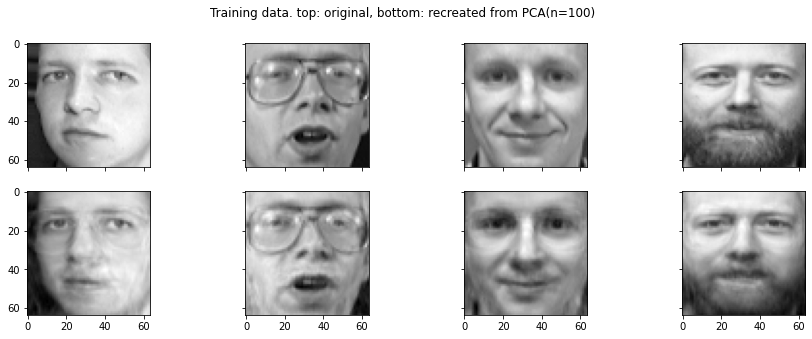

In [38]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('Training data. top: original, bottom: recreated from PCA(n=100)')
for i in range(4):
    axs[0][i].imshow(X_train[i].reshape(64, 64), cmap=plt.cm.gray)
    axs[1][i].imshow(X_train_recreated[i].reshape(64, 64), cmap=plt.cm.gray)

That worked reasonably well. However, the first image from the left shows some very clear distortion, and all images seem to be a bit biased towards people wearing glasses (it shows the outlines of hallucinated glasses even though the original photo does not show any glasses). 

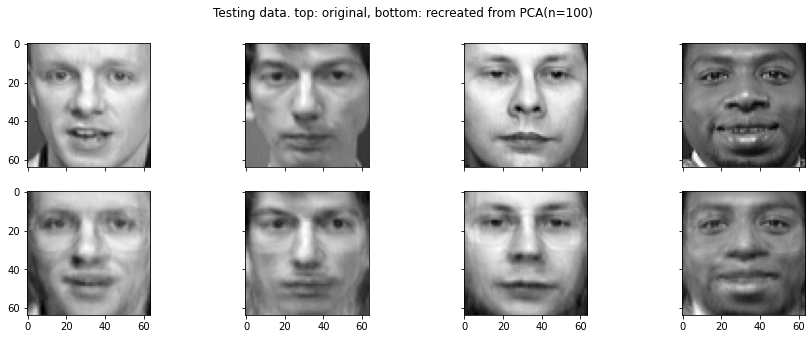

In [40]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('Testing data. top: original, bottom: recreated from PCA(n=100)')
for i in range(4):
    axs[0][i].imshow(X_test[i].reshape(64, 64), cmap=plt.cm.gray)
    axs[1][i].imshow(X_test_recreated[i].reshape(64, 64), cmap=plt.cm.gray)

On the test images, we can see a fair increase in noise. And although nobody in the original images wears glasses, there are noticeable outlines of glasses in the recreated images.

We may want to know how many components the PCA needs in order to recreate the images well. Let us run the PCA with a variety of different values for `n_components` to assess. 

**Note**: we are now testing what value of `n_components` performs best on the testing data. This is not permitted in a real machine learning task: the test data is **only** for evaluating the final performance, you are not allowed to use it to make any decisions about your ML model (such as the hyperparameter `n_components` of the PCA). 

In [44]:
n_values = [1, 5, 50, 100, 200]
pcas = [
    sklearn.decomposition.PCA(n_components=n)
    for n in n_values
]

In [45]:
for pca in pcas:
    pca.fit(X_train)

We will do the dimension reduction and recreation in one line now:

In [49]:
X_test_recreated = [
    pca.inverse_transform(pca.transform(X_test))
    for pca in pcas
]

Let us plot the result for some example faces:

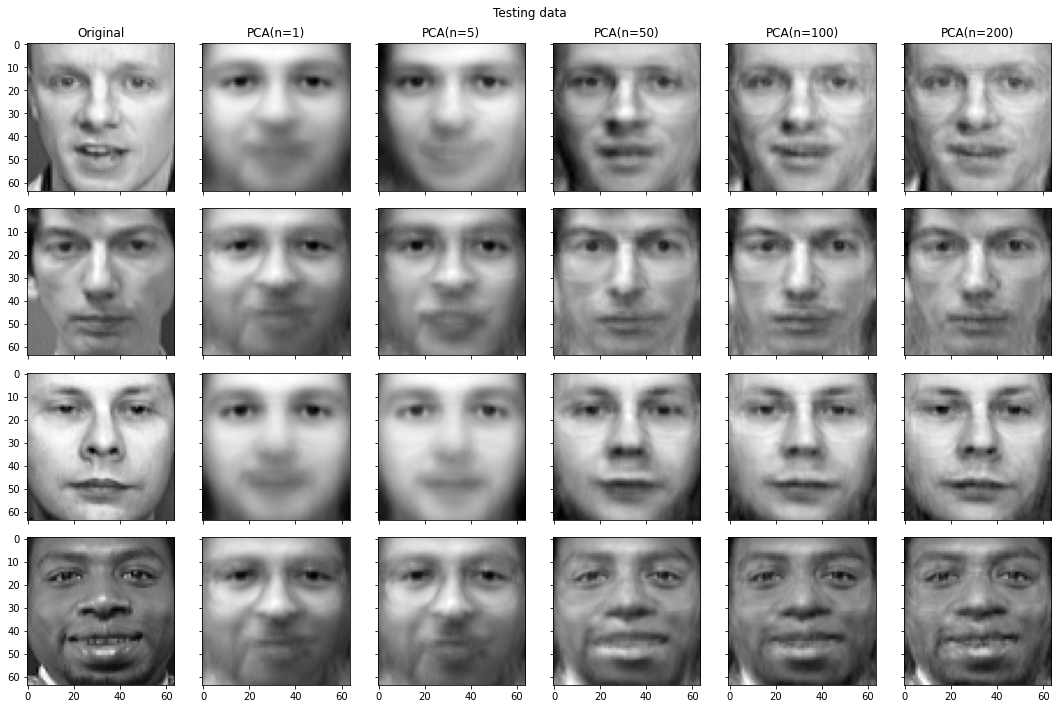

In [55]:
fig, axs = plt.subplots(4, len(n_values)+1, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Testing data')
# set column labels
axs[0][0].set_title('Original')
for idx, n in enumerate(n_values):
    axs[0][idx+1].set_title(f'PCA(n={n})')
# plot data
for i in range(4):
    # original image
    axs[i][0].imshow(X_test[i].reshape(64, 64), cmap=plt.cm.gray)
    # loop over recreated images
    for j in range(len(n_values)):
        axs[i][j+1].imshow(X_test_recreated[j][i].reshape(64, 64), cmap=plt.cm.gray)
fig.tight_layout()

It is also interesting to see the PCA's mean:

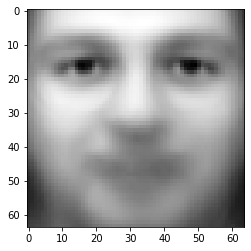

In [62]:
plt.imshow(pcas[0].mean_.reshape(64, 64), cmap=plt.cm.gray);

And we can visualize the so-called eigenfaces (or, more generally, the eigenimages). These are just the principle components, ordered by their importance in the PCA. One can think of these eigenfaces the features that are extracted from the data with the PCA. The recreated face is a linear combination of the eigenfaces (plus the mean face that we visualized above).

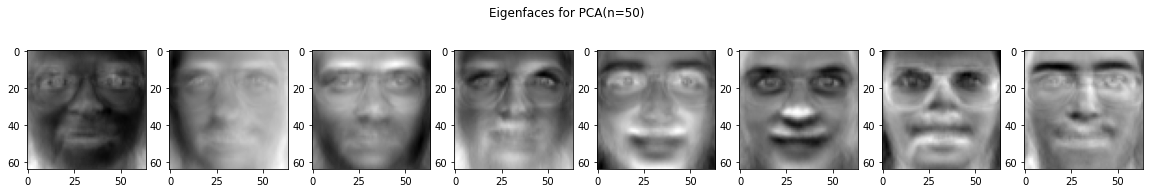

In [71]:
fig, axs = plt.subplots(1, 8, figsize=(20, 3))
fig.suptitle(f'Eigenfaces for PCA(n=50)')
pca50 = pcas[n_values.index(50)]
for i in range(8):
    axs[i].imshow(pca50.components_[i].reshape(64, 64), cmap=plt.cm.gray)

## Classification

We now move on to building a machine learning classifier. The objective is to recognize a person's identity from a photo of their face. We can begin with one of the simplest possible classifiers: a decision tree. Scikit-learn has this classifier built-in. Check out the reference on [their website](https://scikit-learn.org/stable/) to read more about how their SVMs are implemented (and what hyperparameters you can specify). 

In [72]:
dtc = sklearn.tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

We then let this trained model classify the images in our test dataset:

In [73]:
y_pred = dtc.predict(X_test)

We can compute the test accuracy of the model easily:

In [74]:
def compute_accuracy(y_pred, y_true):
    return 1. - np.sum(y_pred != y_test) / y_test.shape[0]

In [78]:
print('Test accuracy: {:.1%}'.format(compute_accuracy(y_pred, y_test)))

Test accuracy: 50.0%


For a more visual interpretation, we can also plot the confusion matrix:

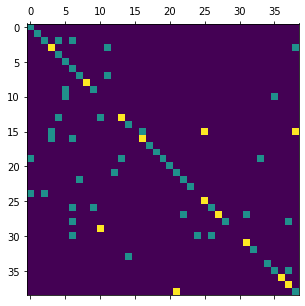

In [79]:
print('Test accuracy: {:.1%}'.format(compute_accuracy(y_pred, y_test)))
confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_test)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.matshow(confusion_matrix)

Off-diagonal entries are misclassifications.

Let's see how well our model is doing on the training data:

Train accuracy: 98.8%


/tmp/ipykernel_51356/425699716.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return 1. - np.sum(y_pred != y_test) / y_test.shape[0]


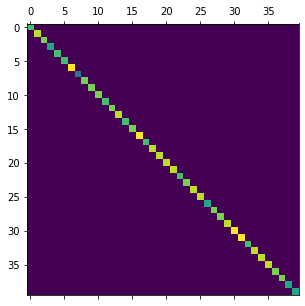

In [85]:
y_pred_train = dtc.predict(X_train)
print('Train accuracy: {:.1%}'.format(compute_accuracy(y_pred_train, y_train)))
confusion_matrix = sklearn.metrics.confusion_matrix(y_pred_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.matshow(confusion_matrix)

Looks like a case of overfitting!

### PCA + classifier

To try and boost our classifier's performance, we could first reduce the dimensionality in our dataset (using PCA), and then train the classifier on the data of reduced dimensionality. This can help prevent overfitting: by reducing the dimensionality of the data well, we essentially help the classifier focus only on those dimensions that actually matter. 

In [111]:
pca = sklearn.decomposition.PCA(n_components=20)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [112]:
dtc_pca = sklearn.tree.DecisionTreeClassifier()
dtc_pca.fit(X_train_reduced, y_train)
y_pred = dtc_pca.predict(X_test_reduced)

Test accuracy: 52.5%


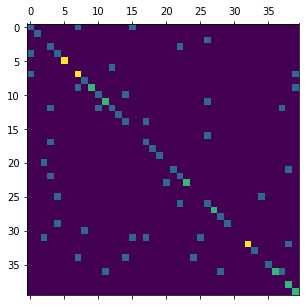

In [113]:
print('Test accuracy: {:.1%}'.format(compute_accuracy(y_pred, y_test)))
confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_test)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.matshow(confusion_matrix)

Train accuracy: 98.8%


/tmp/ipykernel_51356/425699716.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return 1. - np.sum(y_pred != y_test) / y_test.shape[0]


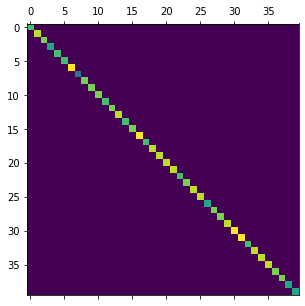

In [114]:
y_pred_train = dtc_pca.predict(X_train_reduced)
print('Train accuracy: {:.1%}'.format(compute_accuracy(y_pred_train, y_train)))
confusion_matrix = sklearn.metrics.confusion_matrix(y_pred_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.matshow(confusion_matrix)

That is not really good enough.. Let's move on to a more powerful model: the random forest classifier. 

### Random forest classifier

The random forest classifier is an ensemble classifier: it runs many different decision trees on different subsets of the training data, and then averages their predictions.

In [115]:
rfc = sklearn.ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Test accuracy: 92.5%


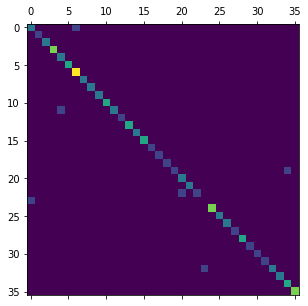

In [116]:
print('Test accuracy: {:.1%}'.format(compute_accuracy(y_pred, y_test)))
confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_test)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.matshow(confusion_matrix)

Train accuracy: 98.8%


/tmp/ipykernel_51356/425699716.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return 1. - np.sum(y_pred != y_test) / y_test.shape[0]


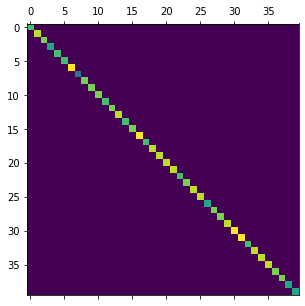

In [118]:
y_pred_train = rfc.predict(X_train)
print('Train accuracy: {:.1%}'.format(compute_accuracy(y_pred_train, y_train)))
confusion_matrix = sklearn.metrics.confusion_matrix(y_pred_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.matshow(confusion_matrix)

Same training accuracy, but significantly better testing accuracy! Call that a win for random forests.

## Completing faces with regression

Next, we move to a different task: regression. We want to train a model that can read in the top half of an image (i.e. the first $n/2$ values in the image vector) and then returns the bottom half of the image (the remaining $n/2$ values). 

We begin by creating our training and testing data and labels:

In [119]:
split = X.shape[1] // 2
X_train = X[:320, :split]
y_train = X[:320, split:]
X_test =  X[320:, :split]
y_test =  X[320:, split:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 2048), (320, 2048), (80, 2048), (80, 2048))

We will only train a simple linear regression model to tackle this task:

In [120]:
lr = sklearn.linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [121]:
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)

To evaluate the model, we compute the MSE on the training data and testing data:

In [137]:
print('Training MSE:', sklearn.metrics.mean_squared_error(y_pred_train, y_train))
print('Testing MSE:', sklearn.metrics.mean_squared_error(y_pred, y_test))

Training MSE: 3.138584e-12
Testing MSE: 0.01645771


Clearly, the linear regression model memorizes the training data very well, but does not do so well on the testing data. 

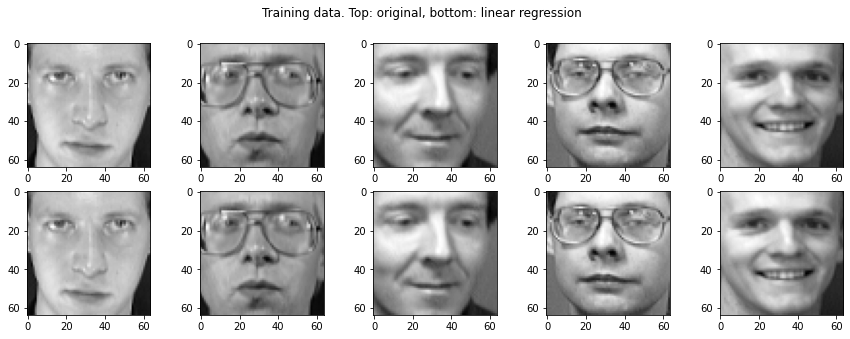

In [125]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
fig.suptitle('Training data. Top: original, bottom: linear regression')
for i in range(5):
    axs[0][i].imshow(X[i*10+2].reshape(64, 64), cmap=plt.cm.gray)
    axs[1][i].imshow(np.concatenate([X_train[i*10+2], y_pred_train[i*10+2]]).reshape(64, 64), cmap=plt.cm.gray)

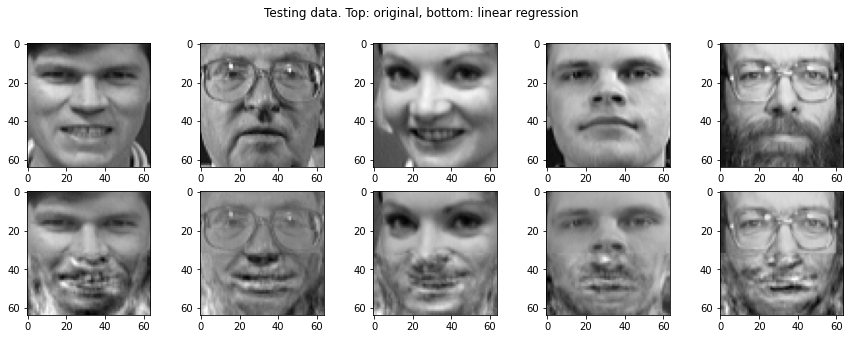

In [126]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
fig.suptitle('Testing data. Top: original, bottom: linear regression')
for i in range(5):
    axs[0][i].imshow(X[320+i*10+2].reshape(64, 64), cmap=plt.cm.gray)
    axs[1][i].imshow(np.concatenate([X_test[i*10+2], y_pred[i*10+2]]).reshape(64, 64), cmap=plt.cm.gray)

I'll leave it up to you to try more powerful regression models to do better on this task! 